In [0]:
import numpy as np
from numba import jit, prange
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Create the data

In [0]:
# @jit(nopython=True, parallel=True, fastmath=True)
def make_errors(errors, errorsi):
    for n in prange(0, 12 + 1):
        errors[n] = (fracs - eq_temps[n]) / eq_temps[n]
        errorsi[n] = (fracsi - eq_temps[12 - n]) / eq_temps[12 - n]

In [0]:
eq_temps = np.zeros(13, dtype=np.longdouble)
for n in range(0, 13):
    eq_temps[n] = 2 ** (n / 12)

In [53]:
eq_temps

array([1.        , 1.05946309, 1.12246205, 1.18920712, 1.25992105,
       1.33483985, 1.41421356, 1.49830708, 1.58740105, 1.68179283,
       1.78179744, 1.88774863, 2.        ], dtype=float128)

In [0]:
max_num = 1000 * 1

In [6]:
%%time
a_s = np.arange(1, max_num + 1, dtype=np.int32)
b_s = 1 / a_s

fracs = np.multiply(a_s.reshape(-1, 1), b_s.reshape(1, -1), dtype=np.float64)  # change to float64 or float128 to gain precision
fracsi = 2 / fracs

CPU times: user 4.94 ms, sys: 8.75 ms, total: 13.7 ms
Wall time: 14.5 ms


In [7]:
%%time
ones = np.ones(max_num, dtype=np.int16)
a_c = np.multiply(a_s.reshape(-1, 1), ones.reshape(1, -1), 
                  dtype=np.int16).reshape((max_num * max_num),)
b_r = np.multiply(a_s.reshape(1, -1), ones.reshape(-1, 1), 
                  dtype=np.int16).reshape((max_num * max_num),)

del ones

CPU times: user 2.55 ms, sys: 2.2 ms, total: 4.75 ms
Wall time: 8.62 ms


In [8]:
%%time
fracs = fracs.reshape((max_num * max_num),)
fracsi = fracsi.reshape((max_num * max_num),)

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 29.6 µs


In [9]:
%%time
errors = [[] for i in range(13)]
errorsi = [[] for i in range(13)]
make_errors(errors, errorsi)

CPU times: user 72 ms, sys: 99.7 ms, total: 172 ms
Wall time: 172 ms


In [10]:
%%time
errors = np.concatenate(errors)
errorsi = np.concatenate(errorsi)

CPU times: user 34 ms, sys: 95.7 ms, total: 130 ms
Wall time: 130 ms


In [11]:
%%time
ns = list()
for i in range(13):
    ns.append(i * np.ones(max_num * max_num, dtype=np.int8))
ns = np.concatenate(ns)

CPU times: user 8.57 ms, sys: 794 µs, total: 9.36 ms
Wall time: 9.12 ms


In [12]:
%%time
a_c = np.tile(a_c, reps=13)
b_r = np.tile(b_r, reps=13)

CPU times: user 12.2 ms, sys: 2 µs, total: 12.2 ms
Wall time: 12.1 ms


In [13]:
%%time
fracs = np.tile(fracs, reps=13)
fracsi = np.tile(fracsi, reps=13)

CPU times: user 34.5 ms, sys: 46.2 ms, total: 80.7 ms
Wall time: 80.4 ms


In [14]:
# The number of rows in a dataframe of the values
f'{max_num * max_num * 13:,}'

'13,000,000'

In [0]:
# %%time
## (Takes up way too much RAM)
# df = pd.DataFrame({'a_s': a_c, 'b_s': b_r,'fracs': fracs, 'fracsi': fracsi, 
#              'n': ns, 'errors': errors, 'errorsi': errorsi})

#### Iterate through and delete each time to minimize RAM

In [16]:
%%time
df = pd.DataFrame({'a_s': a_c, 'b_s': b_r,'fracs': fracs})
del a_c, b_r, fracs

CPU times: user 30.4 ms, sys: 73.5 ms, total: 104 ms
Wall time: 108 ms


In [17]:
%%time
df_temp = pd.DataFrame({'fracsi': fracsi, 'n': ns})
del fracsi, ns

CPU times: user 23.1 ms, sys: 0 ns, total: 23.1 ms
Wall time: 22.6 ms


In [18]:
%%time
df = pd.concat([df, df_temp], axis=1)
del df_temp

CPU times: user 49.5 ms, sys: 49 ms, total: 98.5 ms
Wall time: 99.3 ms


In [19]:
%%time
df_temp = pd.DataFrame({'errors': errors})
del errors

CPU times: user 20.5 ms, sys: 664 µs, total: 21.1 ms
Wall time: 20.6 ms


In [20]:
%%time
df = pd.concat([df, df_temp], axis=1)
del df_temp

CPU times: user 144 ms, sys: 184 ms, total: 328 ms
Wall time: 327 ms


In [21]:
%%time
df_temp = pd.DataFrame({'errorsi': errorsi})
del errorsi

CPU times: user 19.8 ms, sys: 294 µs, total: 20.1 ms
Wall time: 20 ms


In [22]:
%%time
df = pd.concat([df, df_temp], axis=1)
del df_temp

CPU times: user 222 ms, sys: 109 ms, total: 332 ms
Wall time: 336 ms


### Analysis

In [0]:
df['abs_errors'] = abs(df.errors)
df['abs_errorsi'] = abs(df.errorsi)

In [68]:
%%time
max_error = 0.15
# min_error was 0.1
min_error = 0
dfs = df.loc[(min_error <= abs(df.errors)) & (abs(df.errors) <= max_error)]

CPU times: user 388 ms, sys: 152 ms, total: 540 ms
Wall time: 540 ms


In [72]:
dfs.head()

,a_s,b_s,fracs,fracsi,n,errors,errorsi,abs_errors,abs_errorsi
0,1,1,1.000000,2.000000,0,0.000000,0.000000,0.000000,0.000000
5006,6,7,0.857143,2.333333,0,-0.142857,0.166667,0.142857,0.166667
6007,7,8,0.875000,2.285714,0,-0.125000,0.142857,0.125000,0.142857
7006,8,7,1.142857,1.750000,0,0.142857,-0.125000,0.142857,0.125000
7008,8,9,0.888889,2.250000,0,-0.111111,0.125000,0.111111,0.125000


In [0]:
# df.loc[np.gcd(df.a_s, df.b_s) == 1]

In [0]:
dfs = dfs.loc[np.gcd(dfs.a_s, dfs.b_s) == 1]

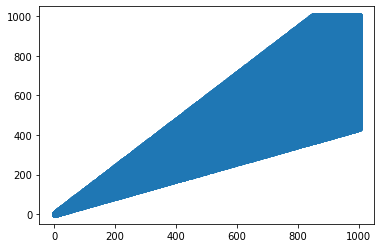

In [71]:
plt.scatter(dfs.a_s, dfs.b_s)

In [73]:
dfs.loc[dfs.n == 2].sort_values(by='abs_errors')

,a_s,b_s,fracs,fracsi,n,errors,errorsi,abs_errors,abs_errorsi
2998889,999,890,1.122472,1.781782,2,0.000009,-0.000009,0.000009,0.000009
2943840,944,841,1.122473,1.781780,2,0.000010,-0.000010,0.000010,0.000010
2888791,889,792,1.122475,1.781777,2,0.000011,-0.000011,0.000011,0.000011
2054048,55,49,1.122449,1.781818,2,-0.000012,0.000012,0.000012,0.000012
2833742,834,743,1.122476,1.781775,2,0.000013,-0.000013,0.000013,0.000013
...,...,...,...,...,...,...,...,...,...
2829642,830,643,1.290824,1.549398,2,0.149994,-0.130430,0.149994,0.130430
2290304,291,305,0.954098,2.096220,2,-0.149995,0.176464,0.149995,0.176464
2576446,577,447,1.290828,1.549393,2,0.149997,-0.130432,0.149997,0.130432
2768805,769,806,0.954094,2.096229,2,-0.149999,0.176469,0.149999,0.176469


In [75]:
dfs.loc[dfs.n == 7].sort_values(by='abs_errors')

,a_s,b_s,fracs,fracsi,n,errors,errorsi,abs_errors,abs_errorsi
7441294,442,295,1.498305,1.334842,7,-0.000001,0.000001,0.000001,0.000001
7886591,887,592,1.498311,1.334837,7,0.000002,-0.000002,0.000002,0.000002
7880587,881,588,1.498299,1.334847,7,-0.000005,0.000005,0.000005,0.000005
7444296,445,297,1.498316,1.334831,7,0.000006,-0.000006,0.000006,0.000006
7438292,439,293,1.498294,1.334852,7,-0.000009,0.000009,0.000009,0.000009
...,...,...,...,...,...,...,...,...,...
7823646,824,647,1.273570,1.570388,7,-0.149994,0.176462,0.149994,0.176462
7814472,815,473,1.723044,1.160736,7,0.149994,-0.130430,0.149994,0.130430
7688540,689,541,1.273567,1.570392,7,-0.149996,0.176465,0.149996,0.176465
7926537,927,538,1.723048,1.160734,7,0.149997,-0.130432,0.149997,0.130432


In [76]:
2 ** (7/12)

1.4983070768766815

In [78]:
3 / 2

1.5

## Fork analysis

In [0]:
# # the warnings are false positives
# dfs['mid'] = (1.056 * abs(dfs.errors) - (5 / 1000))
# dfs['fork'] = dfs.errorsi > dfs.mid
# dfs['fork'] = dfs.fork.astype('int8')
# dfs = dfs.drop(columns=['mid'])

In [0]:
# abserrors = abs(dfs.errors).tolist()
# abserrorsi = abs(dfs.errorsi).tolist()
# plt.scatter(abserrors, abserrorsi)

In [0]:
dfs.corr()

In [0]:
dfs.shape

(31886290, 8)

In [0]:
dfs.fork.value_counts()

1    21356665
0    10529625
Name: fork, dtype: int64

In [0]:
21356665 / (10529625 + 21356665)

0.6697757876504291

It turns out that the fork of the inverse error (higher or lower) is completely predicted by the sign of the original error, such that if the starting fraction is lower than the equal temperament value (the original error is negative), then the inverse fraction will be greater than the inverse equal temperament by a greater amount than if the starting fraction was greater than the equal temperament value. 

In [0]:
(1 - ((np.sign(dfs.errors) + 1) / 2).astype(np.int8) == dfs.fork).unique()

array([ True])

The error and inverse error are always opposite sign.

In [0]:
(np.sign(dfs.errors) == np.sign(dfs.errorsi)).unique()

array([False])

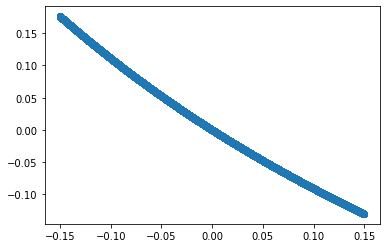

In [26]:
plt.scatter(dfs.errors, dfs.errorsi)

In [0]:
x = np.arange(0.1, 0.3, 0.001)
y_low = (13 / 16) * x + (7 / 800)
y_high = (13 / 10) * x - (19 / 1000)
y = 1.056 * x - (5 / 1000)

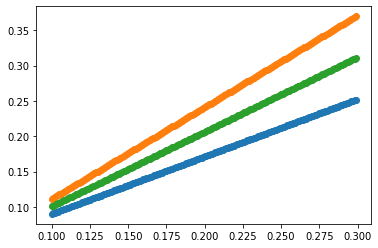

In [0]:
plt.scatter(x, y_low)
plt.scatter(x, y_high)
plt.scatter(x, y)
# plt.ylim(0.09, 0.4) 